# KNN Classifier

The effect of reducing K in the k-nearest neighbors classifier is to increase the variance of the decision boundaries, because the decision boundary can be affected by outliers. If there's a point far, far away, it might have, it has much greater effect on the decision boundary in the K=1 case, than it would in the K=10 case, when the votes of nine other neighbors are also needed. And so, you can see that by adjusting the value of K for the k-nearest neighbors classifier, we can control in some sense, the degree of model fitting that's appropriate for a dataset. Now, the actual value of k that works best can only be determined by evaluating on a test set. But the general idea is that as we decrease K for k-NN classifiers, we increase the risk of overfitting. Because, for the reasons I mentioned before, where K=1 for example, we're trying to capture very local changes in the decision boundary that may not lead to good generalization behavior for future data.

## Import required modules and load data file

In [5]:
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as sps

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

# import graphviz

from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification, make_regression

## Example1-Fruits Data

### Check Data

In [39]:
fruits = pd.read_table('fruit_data_with_colors.txt')
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [40]:
fruits.shape

(59, 7)

In [41]:
features = fruits.columns[-4:].tolist()
features

['mass', 'width', 'height', 'color_score']

In [42]:
# create a mapping from fruit label value to fruit name to make results easier to interpret
lookup_fruit_name = dict(zip(fruits.fruit_label.unique(),fruits.fruit_name.unique()))   
lookup_fruit_name

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

The file contains the mass, height, and width of a selection of oranges, lemons and apples. The heights were measured along the core of the fruit. The widths were the widest width perpendicular to the height.

### Plot data

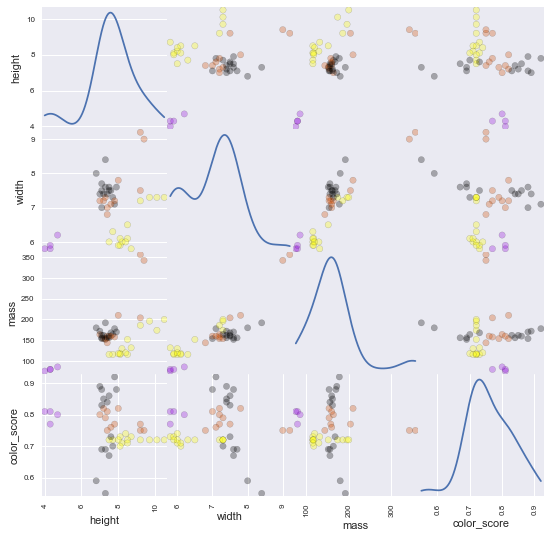

In [44]:
# plotting a scatter matrix

X = fruits[['height', 'width', 'mass', 'color_score']]
y = fruits['fruit_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(X_train, c= y_train, marker = 'o', diagonal='kde',
                            s=40, hist_kwds={'bins':30}, alpha=0.3, edgecolors='black',
                            figsize=(9,9),cmap=cmap)
plt.show()
# FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead

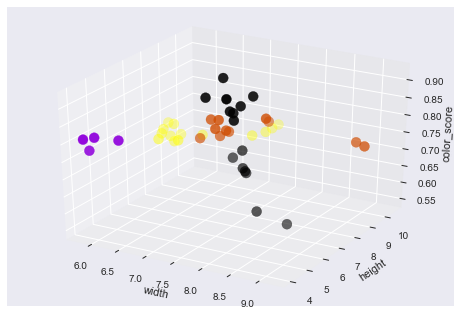

In [45]:
# plotting a 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_train['width'], X_train['height'], X_train['color_score'], 
           c = y_train, marker = 'o', s=100, cmap=cmap)
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.set_zlabel('color_score')
plt.show()

In [46]:
import seaborn as sns
import scipy.stats as sps

In [47]:
def corrfunc(x, y, **kws):
    (r, p) = sps.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

In [48]:
df1 = pd.concat([X_train, y_train],axis= 1)

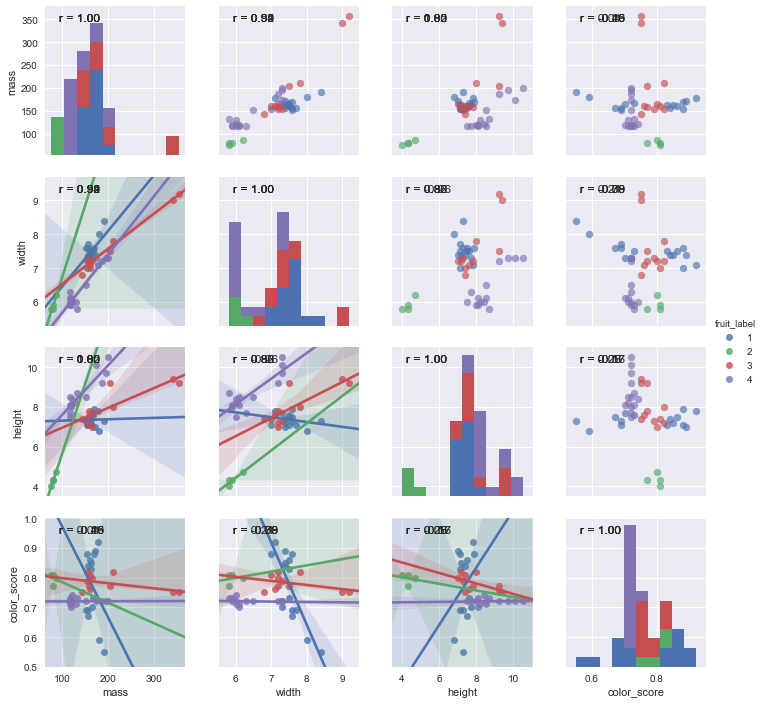

In [51]:
# Other way to generate the same type of plot
fig = sns.PairGrid(df1, hue='fruit_label', vars=fruits.columns[3:].tolist())
fig = fig.map_diag(plt.hist)
fig = fig.map_upper(plt.scatter, alpha=0.65)
fig = fig.map_lower(sns.regplot)
fig = fig.add_legend()
fig = fig.map(corrfunc)
# Get hold of the axes objects (an array of axes)
axes = fig.axes
axes[3, 0].set_ylim(0.50, 1.0)
axes[1, 0].set_ylim(df1['width'].min() - 0.5, df1['width'].max() + 0.5)
axes[2, 0].set_ylim(df1['height'].min() - 0.5, df1['height'].max() + 0.5)
plt.show()

### Creat KNN Classifier

In [139]:
# For this example, we use the mass, width, and height features of each fruit instance
X = fruits[['mass', 'width', 'height']]
y = fruits['fruit_label']

# default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

knn = KNeighborsClassifier(n_neighbors = 5)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

* weights 是在进行分类判断时给最近邻附上的加权，默认的 'uniform' 是等权加权，还有 'distance' 选项是按照距离的倒数进行加权
* algorithm 是分类时采取的算法，有 'brute'、'kd_tree' 和 'ball_tree'。kd_tree 的算法在 kd 树文章中有详细介绍，而 ball_tree 是另一种基于树状结构的 kNN 算法，brute 则是最直接的蛮力计算。根据样本量的大小和特征的维度数量，不同的算法有各自的优势。默认的 'auto' 选项会在学习时自动选择最合适的算法，所以一般来讲选择 auto 就可以
* leaf_size 是 kd_tree 或 ball_tree 生成的树的树叶（树叶就是二叉树中没有分枝的节点）的大小。在 kd 树文章中我们所有的二叉树的叶子中都只有一个数据点，但实际上树叶中可以有多于一个的数据点，算法在达到叶子时在其中执行蛮力计算即可。对于很多使用场景来说，叶子的大小并不是很重要，我们设 leaf_size=1 就好。

* metric 和 p，是距离函数选项，如果 metric ='minkowski' 并且 p=p 的话，计算两点之间的距离就是
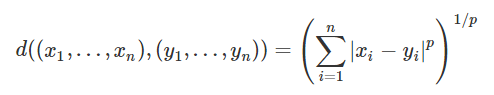
一般来讲，默认的 metric='minkowski'（默认）和 p=2（默认）就可以满足大部分需求。其他的 metric 选项可见说明文档。metric_params 是一些特殊 metric 选项需要的特定参数，默认是 None。

* n_jobs 是并行计算的线程数量，默认是 1，输入 -1 则设为 CPU 的内核数。

In [140]:
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.53333333333333333

In [7]:
accuracy_score(y_test, knn.predict(X_test))

0.53333333333333333

In [131]:
isinstance(X, (np.ndarray,))

False

In [137]:
isinstance(MinMaxScaler().fit_transform(X), (np.ndarray,))

True

In [132]:
isinstance(X, (pd.DataFrame,))

True

### Use the trained k-NN classifier model to classify new, previously unseen objects

In [8]:
# first example: a small fruit with mass 20g, width 4.3 cm, height 5.5 cm
fruit_prediction = knn.predict([[20, 4.3, 5.5]])
fruit_prediction

array([2], dtype=int64)

In [9]:
lookup_fruit_name[fruit_prediction[0]]

'mandarin'

In [10]:
# second example: a larger, elongated fruit with mass 100g, width 6.3 cm, height 8.5 cm
fruit_prediction = knn.predict([[100, 6.3, 8.5]])
fruit_prediction

array([4], dtype=int64)

In [11]:
lookup_fruit_name[fruit_prediction[0]]

'lemon'

### Plot the decision boundaries of the k-NN classifier

In [12]:
np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]

array([[1, 2, 3, 0, 0, 4, 5, 6]])

In [13]:
np.ravel([np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])])

array([array([[1, 2, 3]]), 0, 0, array([[4, 5, 6]])], dtype=object)

In [14]:
def plot_fruit_knn(X, y, n_neighbors, weights):
    if isinstance(X, (pd.DataFrame,)):
        X_mat = X[['height', 'width']].as_matrix() # 将X变为矩阵
        y_mat = y.as_matrix()
    elif isinstance(X, (np.ndarray,)):
        # When X was scaled is already a matrix
        X_mat = X_mat[:, :2]
        y_mat = y.as_matrix()
        print(X_mat)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])

    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                         np.arange(y_min, y_max, mesh_step_size))
    # numpy.c_ Translates slice objects to concatenation along the second axis
    # e.g. np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]--array([[1, 2, 3, 0, 0, 4, 5, 6]])
    # ravel() Returns a contiguous flattened array.
    # x = np.array([[1, 2, 3], [4, 5, 6]])
    # np.ravel(x) = [1 2 3 4 5 6]

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    patch0 = mpatches.Patch(color='#FF0000', label='apple')
    patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    patch2 = mpatches.Patch(color='#0000FF', label='orange')
    patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    plt.legend(handles=[patch0, patch1, patch2, patch3])


    plt.xlabel('height (cm)')
    plt.ylabel('width (cm)')

    plt.show()

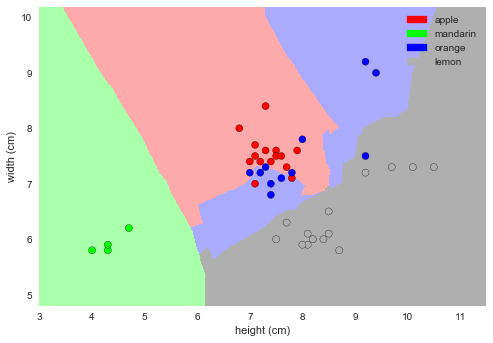

In [15]:
# from adspy_shared_utilities import plot_fruit_knn
plot_fruit_knn(X_train, y_train, 5, 'uniform') 

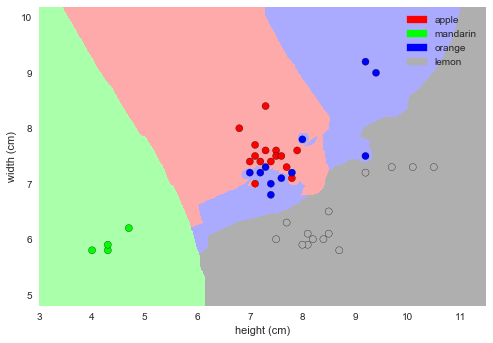

In [16]:
plot_fruit_knn(X_train, y_train, 5, 'distance') 

### How sensitive is k-NN classification accuracy to the choice of the 'k' parameter?

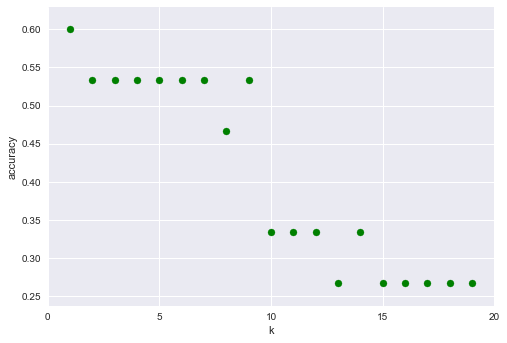

In [19]:
k_range = range(1,20)
scores = []


for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores, color='green')
plt.xticks([0,5,10,15,20])
plt.show()

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
#X_test_scaled = scaler.transform(X_test)

#xpred = np.array([20,4.3,5.5,8.7]).reshape(-1,4)
for K in range(1,20):
    knn = KNeighborsClassifier(n_neighbors = K).fit(X_train, y_train)
    #y_pred = knn.predict(xpred)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    print('When K={}, then Train score is: {:.3f} and Test score is: {:.3f}'.format(K, train_score, test_score))

When K=1, then Train score is: 1.000 and Test score is: 0.600
When K=2, then Train score is: 0.886 and Test score is: 0.533
When K=3, then Train score is: 0.818 and Test score is: 0.533
When K=4, then Train score is: 0.795 and Test score is: 0.533
When K=5, then Train score is: 0.795 and Test score is: 0.533
When K=6, then Train score is: 0.727 and Test score is: 0.600
When K=7, then Train score is: 0.750 and Test score is: 0.533
When K=8, then Train score is: 0.682 and Test score is: 0.467
When K=9, then Train score is: 0.636 and Test score is: 0.533
When K=10, then Train score is: 0.591 and Test score is: 0.333
When K=11, then Train score is: 0.591 and Test score is: 0.333
When K=12, then Train score is: 0.545 and Test score is: 0.333
When K=13, then Train score is: 0.545 and Test score is: 0.267
When K=14, then Train score is: 0.568 and Test score is: 0.333
When K=15, then Train score is: 0.545 and Test score is: 0.267
When K=16, then Train score is: 0.545 and Test score is: 0.267
W

### How sensitive is k-NN classification accuracy to the train/test split proportion?

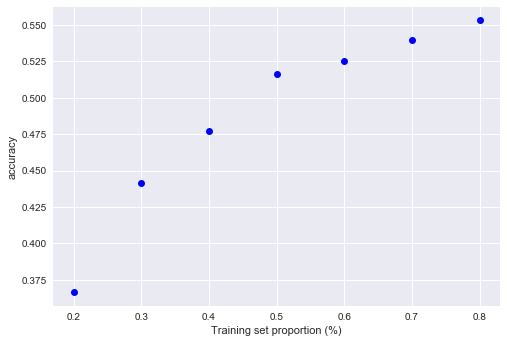

In [21]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 5)

plt.figure()

for s in t:

    scores = []
    for i in range(1,1000):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s)
            knn.fit(X_train, y_train)
            scores.append(knn.score(X_test, y_test))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy')
plt.show()

### Data After Standarization

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

#xpred = np.array([20,4.3,5.5,8.7]).reshape(-1,4)
for K in range(1,20):
    knn = KNeighborsClassifier(n_neighbors = K).fit(X_train_scaled, y_train)
    #y_pred = knn.predict(xpred)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    print('When K={}, then Train score is: {:.3f} and Test score is: {:.3f}'.format(K, train_score, test_score))

When K=1, then Train score is: 1.000 and Test score is: 0.867
When K=2, then Train score is: 0.977 and Test score is: 0.867
When K=3, then Train score is: 0.955 and Test score is: 0.933
When K=4, then Train score is: 0.955 and Test score is: 0.933
When K=5, then Train score is: 0.955 and Test score is: 1.000
When K=6, then Train score is: 0.955 and Test score is: 0.867
When K=7, then Train score is: 0.955 and Test score is: 0.867
When K=8, then Train score is: 0.932 and Test score is: 0.867
When K=9, then Train score is: 0.977 and Test score is: 0.933
When K=10, then Train score is: 0.932 and Test score is: 0.933
When K=11, then Train score is: 0.955 and Test score is: 0.867
When K=12, then Train score is: 0.841 and Test score is: 0.800
When K=13, then Train score is: 0.841 and Test score is: 0.933
When K=14, then Train score is: 0.568 and Test score is: 0.600
When K=15, then Train score is: 0.568 and Test score is: 0.600
When K=16, then Train score is: 0.545 and Test score is: 0.467
W

## Example 2-C2


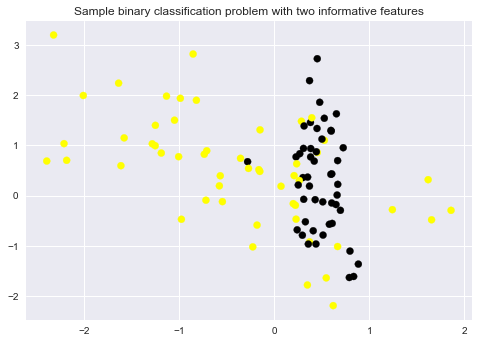

In [55]:
plt.figure()
cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])
plt.title('Sample binary classification problem with two informative features')
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0) 

# n_redundant:The number of redundant features. These features are generated as random linear combinations of the informative features.
# n_cluster_per_class: The number of clusters per class

plt.scatter(X_C2[:, 0], X_C2[:, 1], c=y_C2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

In [56]:
X_C2.shape

(100, 2)

In [58]:
X_C2[:5]

array([[ 0.37163989, -0.92276158],
       [-0.1617182 ,  0.51386743],
       [-1.63650855,  2.23389996],
       [ 0.62041909, -2.18941375],
       [-0.98718544,  1.93299453]])

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,
                                                   random_state=0)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

for K in [1, 3, 5]:
    knn = KNeighborsClassifier(n_neighbors = K).fit(X_train_scaled, y_train)
    # y_predict_output = knn.predict(np.array([20, 4.3, 5.5]).reshape(-1,1))
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    print('When K={}, then Train score is: {:.3f} and Test score is: {:.3f}'.format(K, train_score, test_score))

When K=1, then Train score is: 1.000 and Test score is: 0.800
When K=3, then Train score is: 0.933 and Test score is: 0.760
When K=5, then Train score is: 0.840 and Test score is: 0.840


In [73]:
def plot_two_class_knn(X, y, n_neighbors, weights, X_test, y_test):
    X_mat = X
    y_mat = y

    # Create color maps
    cmap_light = ListedColormap(['#FFFFAA', '#AAFFAA', '#AAAAFF','#EFEFEF'])
    cmap_bold  = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                         np.arange(y_min, y_max, mesh_step_size))
    # numpy.c_ Translates slice objects to concatenation along the second axis
    # e.g. np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
    # ravel() Returns a contiguous flattened array.
    # x = np.array([[1, 2, 3], [4, 5, 6]])
    # np.ravel(x) = [1 2 3 4 5 6]

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = "Neighbors = {}".format(n_neighbors)
    if (X_test is not None):
        train_score = clf.score(X_mat, y_mat)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    patch0 = mpatches.Patch(color='#FFFF00', label='class 0')
    patch1 = mpatches.Patch(color='#000000', label='class 1')
    plt.legend(handles=[patch0, patch1])

    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)

    plt.show()

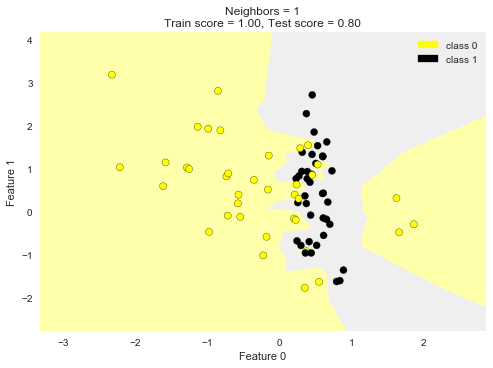

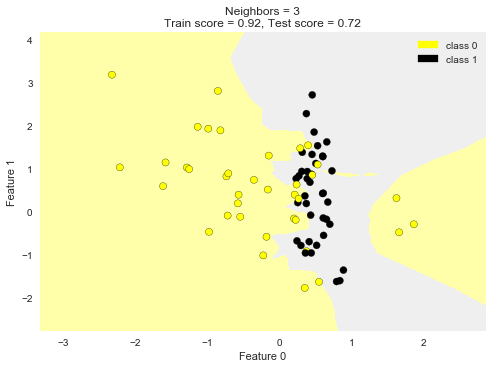

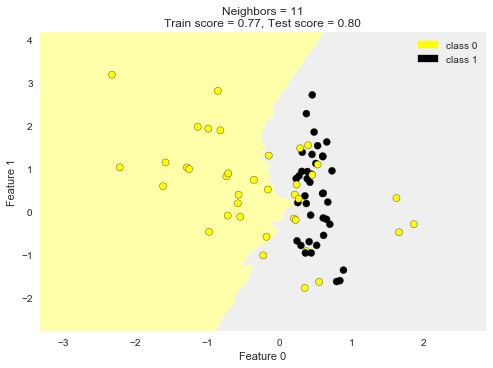

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,
                                                   random_state=0)

plot_two_class_knn(X_train, y_train, 1, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 3, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 11, 'uniform', X_test, y_test)

## Plot KNN

kNN 分类图只能展示两个维度的数据，超过三个特征的话就画不出来了。

In [98]:
def plot_knn(X, y, n_neighbors, weights, X_test, y_test):
    if isinstance(X, (pd.DataFrame,)):
        X_mat = X.as_matrix() # 将X变为矩阵
        y_mat = y.as_matrix()
    elif isinstance(X, (np.ndarray,)):
        # When X was scaled is already a matrix
        X_mat = X
        y_mat = y

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])

    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                         np.arange(y_min, y_max, mesh_step_size))
    # numpy.c_ Translates slice objects to concatenation along the second axis
    # e.g. np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]--array([[1, 2, 3, 0, 0, 4, 5, 6]])
    # ravel() Returns a contiguous flattened array.
    # x = np.array([[1, 2, 3], [4, 5, 6]])
    # np.ravel(x) = [1 2 3 4 5 6]

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = "Neighbors = {}".format(n_neighbors)
    if (X_test is not None):
        train_score = clf.score(X_mat, y_mat)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)
    
    # 如果y类别有四类，就需要4个patch
    #patch0 = mpatches.Patch(color='#FF0000', label='apple')
    #patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    #patch2 = mpatches.Patch(color='#0000FF', label='orange')
    #patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    #plt.legend(handles=[patch0, patch1, patch2, patch3])

    plt.xlabel('Feature 0') # x变量名
    plt.ylabel('Feature 1') # y变量名
    plt.title(title)
    plt.show()

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,
                                                   random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

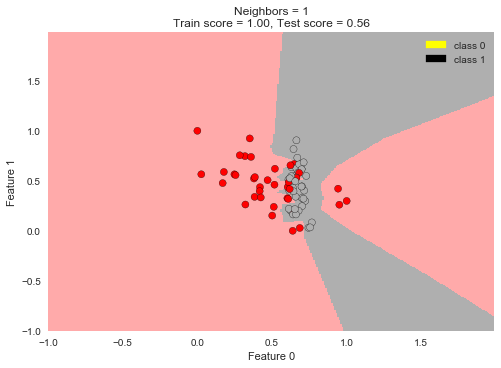

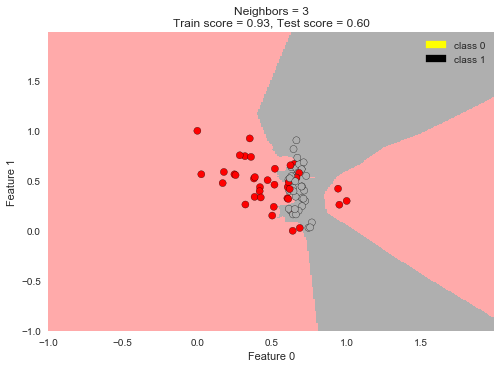

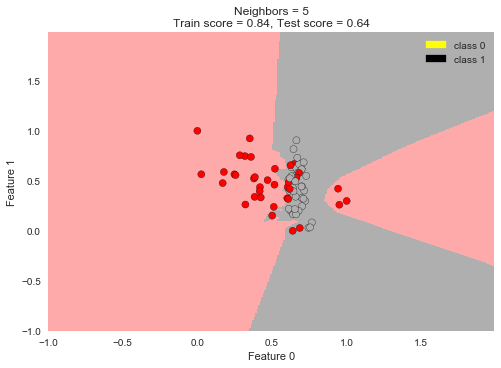

In [100]:
plot_knn(X_train_scaled, y_train, 1, 'uniform', X_test, y_test)
plot_knn(X_train_scaled, y_train, 3, 'uniform', X_test, y_test)
plot_knn(X_train_scaled, y_train, 5, 'uniform', X_test, y_test)

In [101]:
X_fruit = fruits[['width', 'height']]
y_fruit = fruits['fruit_label']

X_train, X_test, y_train, y_test = train_test_split(X_fruit, y_fruit,
                                                   random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

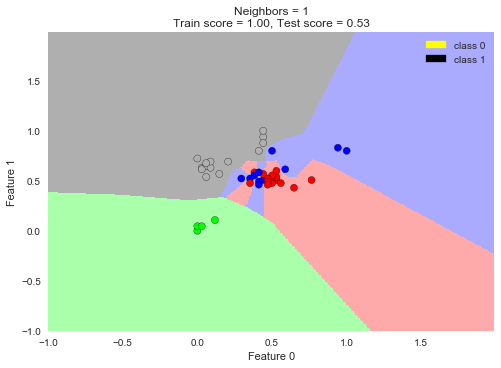

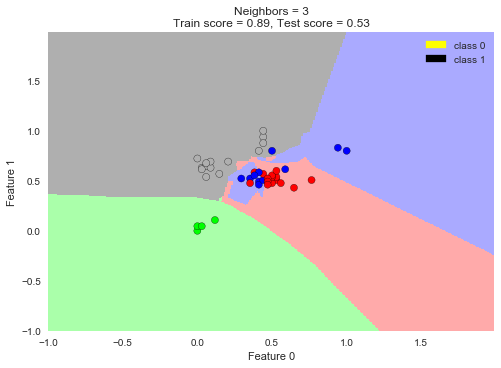

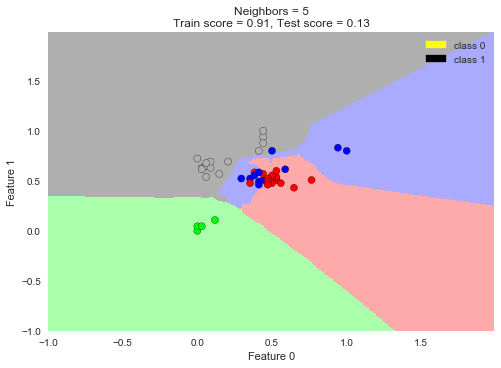

In [102]:
plot_knn(X_train_scaled, y_train, 1, 'uniform', X_test, y_test)
plot_knn(X_train_scaled, y_train, 3, 'uniform', X_test, y_test)
plot_knn(X_train_scaled, y_train, 5, 'uniform', X_test, y_test)

# KNN Regressor

## Data

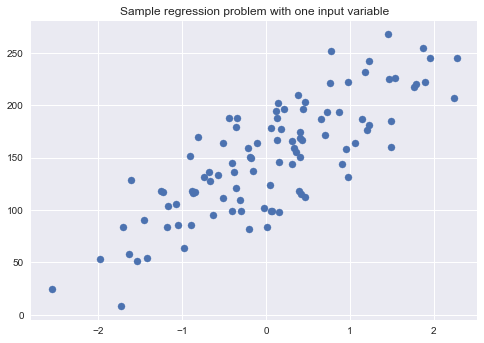

In [109]:
plt.figure()
plt.title('Sample regression problem with one input variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

## Creat KNN Regressor

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state = 0)

knnreg = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)

print(knnreg.predict(X_test))
print('R-squared test score: {:.3f}'.format(knnreg.score(X_test, y_test)))

[ 231.70974697  148.35572605  150.58852659  150.58852659   72.14859259
  166.50590948  141.90634426  235.57098756  208.25897836  102.10462746
  191.31852674  134.50044902  228.32181403  148.35572605  159.16911306
  113.46875166  144.03646012  199.23189853  143.19242433  166.50590948
  231.70974697  208.25897836  128.01545355  123.14247619  141.90634426]
R-squared test score: 0.425


## How sensitive is k-NN Regressor accuracy to the choice of the 'k' parameter?¶

In [121]:
X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state = 0)

for K in [1, 3, 5, 7, 15]:
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    train_score = knnreg.score(X_train, y_train)
    test_score = knnreg.score(X_test, y_test)
    print('When K={}, then Train score is: {:.3f} and Test score is: {:.3f}'.format(K, train_score, test_score))

When K=1, then Train score is: 1.000 and Test score is: 0.155
When K=3, then Train score is: 0.797 and Test score is: 0.323
When K=5, then Train score is: 0.745 and Test score is: 0.425
When K=7, then Train score is: 0.720 and Test score is: 0.471
When K=15, then Train score is: 0.647 and Test score is: 0.485


## Plot KNN Regressor

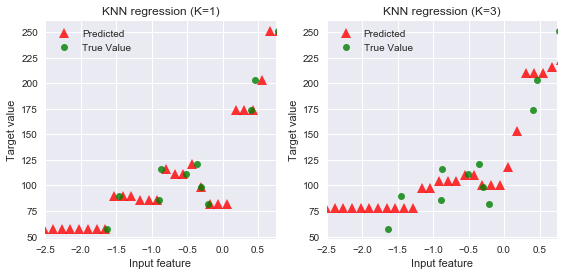

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

for thisaxis, K in zip(axes, [1, 3]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    thisaxis.set_xlim([-2.5, 0.75])
    thisaxis.plot(X_predict_input, y_predict_output, 'r^', markersize = 10,label='Predicted', alpha=0.8)
    thisaxis.plot(X_train, y_train, 'go', label='True Value', alpha=0.8)
    thisaxis.set_xlabel('Input feature')
    thisaxis.set_ylabel('Target value')
    thisaxis.set_title('KNN regression (K={})'.format(K))
    thisaxis.legend()
plt.tight_layout()
plt.show()

## Regression model complexity as a function of K

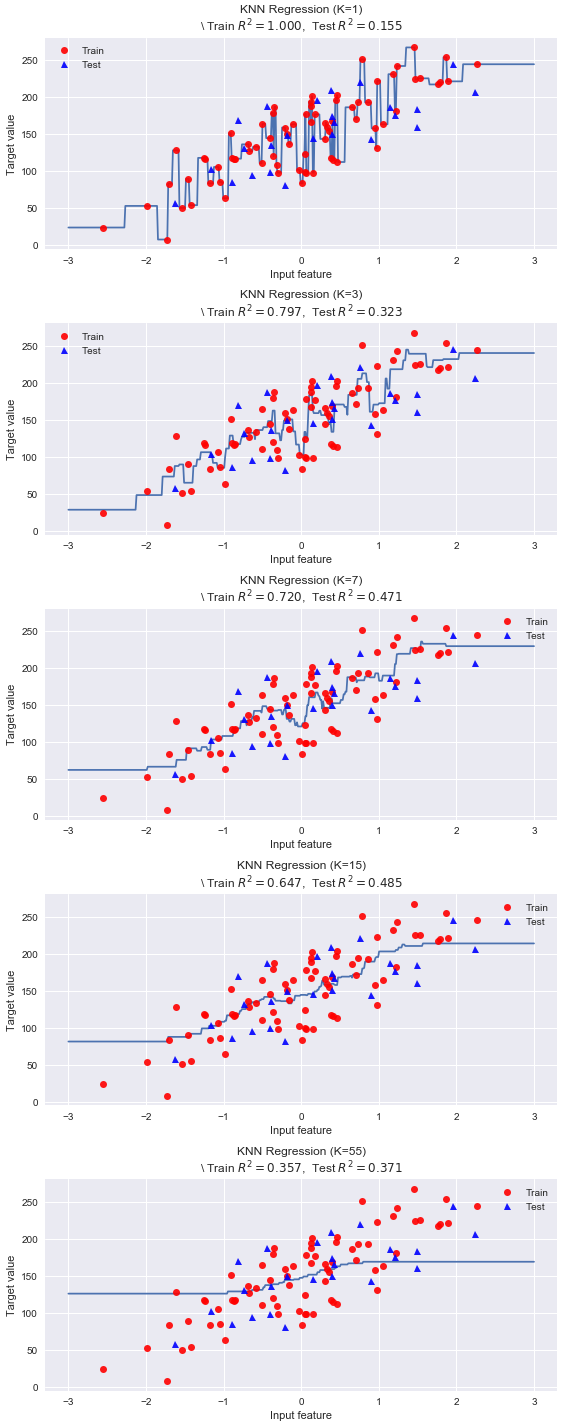

In [129]:
# plot k-NN regression on sample dataset for different values of K
fig, subaxes = plt.subplots(5, 1, figsize=(8,20))
X_predict_input = np.linspace(-3, 3, 500).reshape(-1,1)
# X_R1, y_R1 from regresion of one input variable (above)
X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state = 0)

for thisaxis, K in zip(subaxes, [1, 3, 7, 15, 55]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    train_score = knnreg.score(X_train, y_train)
    test_score = knnreg.score(X_test, y_test)
    thisaxis.plot(X_predict_input, y_predict_output)
    thisaxis.plot(X_train, y_train, 'ro', alpha=0.9, label='Train')
    thisaxis.plot(X_test, y_test, 'b^', alpha=0.9, label='Test')
    thisaxis.set_xlabel('Input feature')
    thisaxis.set_ylabel('Target value')
    thisaxis.set_title('KNN Regression (K={})\n\ Train $R^2 = {:.3f}$,  Test $R^2 = {:.3f}$'
                      .format(K, train_score, test_score))
    thisaxis.legend()
    
plt.tight_layout() #pad=0.4, w_pad=0.5, h_pad=1.0
plt.show()

# Notes

In [ ]:
type只能对类型作直接判断，而isinstance功能比type更强，可以对子类

的类型做出推理判断。

In [3]:
dff = pd.DataFrame({'y':np.arange(4)})
dff

,y
0,0
1,1
2,2
3,3


In [4]:
list(map(chr,[66,53,0,94]))

['B', '5', '\x00', '^']